In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# We need to join the upper directory in order to access the local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import itertools
import json
import logging

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import scipy

from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat, savemat

ModuleNotFoundError: No module named 'seaborn'

In [5]:
from pytdoa.mlat import exact, lls, nlls
from pytdoa.pytdoa import brutefoptim, nonlinoptim, linoptim
from pytdoa.util import generate_heatmap, generate_hyperbola
from pytdoa.geodesy.geodesy import SPEED_OF_LIGHT

In [6]:
fs = 92.16e6
oversample = 16

In [7]:
# Reading the mat files

# gNodeB's
gNB_1 = loadmat('tdoa_5g_loc/pos_gNB_1.mat')['pos_gNB_1']
gNB_2 = loadmat('tdoa_5g_loc/pos_gNB_2.mat')['pos_gNB_2']
gNB_3 = loadmat('tdoa_5g_loc/pos_gNB_3.mat')['pos_gNB_3']

# TOAs per gNodeB
TOA_a = loadmat('tdoa_5g_loc/ToA_All.mat')['ToA_All']

# UE position
UE_po = loadmat('tdoa_5g_loc/pos_UE_vector.mat')['pos_UE_vector']

cij_meas = np.array([21.64, 14.84, 6.79])

In [8]:
selected_positions = np.arange(2,17)

In [9]:
num_positions = UE_po.shape[1]

## Playing a bit with each of the positions (there are 17 in total)

In [16]:
POSITION = 2

gNB_1i = gNB_1[:,POSITION]
gNB_2i = gNB_2[:,POSITION]
gNB_3i = gNB_3[:,POSITION]

TOA_ai = TOA_a[:,POSITION,:].squeeze().T
TOA_ai = TOA_ai[~np.isnan(TOA_ai).any(axis=1)].T

UE_poi = UE_po[:,POSITION]

gNBs = pd.DataFrame(np.array([gNB_1i,gNB_2i,gNB_3i]),columns=[['x','y']])

print(f"User Position: {UE_poi}")

User Position: [7. 3.]


In [17]:
EXPERIMENT = 990

# Uniform convolution
N = 30
TOA_av = uniform_filter1d(TOA_ai, size=N, mode='wrap')
TDOA_av_total = np.array([TOA_av[0,:]-TOA_av[1,:], TOA_av[0,:]-TOA_av[2,:], TOA_av[1,:]-TOA_av[2,:]])
DDOA_av_total = TDOA_av_total / (fs * oversample) * SPEED_OF_LIGHT

TDOA_av = TDOA_av_total[:,EXPERIMENT].squeeze()
DDOA_av = DDOA_av_total[:,EXPERIMENT].squeeze()
print(f"Measured DDOA: {DDOA_av.reshape(1,-1)}")

# Theoretical results
DOA_th = np.sqrt(np.sum(np.square(UE_poi - gNBs), axis=1))
DDOA_th = np.array([DOA_th[0]-DOA_th[1], DOA_th[0]-DOA_th[2], DOA_th[1]-DOA_th[2]])
print(f"DDOA Theoretical: {DDOA_th.reshape(1,-1)}")

cij_p0 = ((DDOA_av_total - DDOA_th.reshape(-1,1)) * (fs*oversample) / SPEED_OF_LIGHT)
cij_avg = np.mean(cij_p0, axis=1)
print(f"cij (samples): {cij_avg.reshape(1,-1)}")
print(f"cij (meters): {(cij_avg * SPEED_OF_LIGHT / (fs*oversample)).reshape(1,-1)}")

TDOA_av2 = TDOA_av - cij_avg
DDOA_av2 = TDOA_av2 / (fs * oversample) * SPEED_OF_LIGHT

Measured DDOA: [[-4.65579379 -4.31694417  0.33884962]]
DDOA Theoretical: [[-2.78821456 -3.09577311 -0.30755855]]
cij (samples): [[-4.87449782 -1.73682352  3.1376743 ]]
cij (meters): [[-0.99103304 -0.35311319  0.63791985]]


In [18]:
position_fang = linoptim(gNBs,DDOA_av[0:2],input_type="xyz")
position_fang

array([ 7.86036701, -0.65963299])

In [19]:
combination_range = itertools.combinations(np.arange(len(gNBs)), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

position_nlls = nonlinoptim(gNBs, DDOA_av2, combinations, num_dim=2, input_type="xyz", method="SLSQP")
position_nlls

array([[6.89654276, 5.23703696]])

In [20]:
position_brut = brutefoptim(gNBs, DDOA_av, combinations, xrange=10, yrange=10, step=1, epsilon=1e-5, num_dim=2, input_type="xyz")
position_brut

array([7.05512533, 5.57097611])

In [21]:
print(f"Algebraic: {np.sqrt(np.sum((UE_poi-position_fang)**2))}")
print(f"NLLS: {np.sqrt(np.sum((UE_poi-position_nlls)**2))}")
print(f"BruteForce: {np.sqrt(np.sum((UE_poi-position_brut)**2))}")

Algebraic: 3.759407535569067
NLLS: 2.23942800339845
BruteForce: 2.5715670216067457


## Loop Results

In [9]:
import pickle
from datetime import datetime

In [31]:
POSITION = 2

gNB_1i = gNB_1[:,POSITION]
gNB_2i = gNB_2[:,POSITION]
gNB_3i = gNB_3[:,POSITION]

TOA_ai = TOA_a[:,POSITION,:].squeeze().T
TOA_ai = TOA_ai[~np.isnan(TOA_ai).any(axis=1)].T

UE_poi = UE_po[:,POSITION]

gNBs = pd.DataFrame(np.array([gNB_1i,gNB_2i,gNB_3i]),columns=[['x','y']])

EXPERIMENT = 990

# Uniform convolution
N = 30
TOA_av = uniform_filter1d(TOA_ai, size=N, mode='wrap',axis=1)
TDOA_av_total = np.array([TOA_av[0,:]-TOA_av[1,:], TOA_av[0,:]-TOA_av[2,:], TOA_av[1,:]-TOA_av[2,:]])
DDOA_av_total = TDOA_av_total / (fs * oversample) * SPEED_OF_LIGHT

# Theoretical results
DOA_th = np.sqrt(np.sum(np.square(UE_poi - gNBs.to_numpy()), axis=1))
DDOA_th = np.array([DOA_th[0]-DOA_th[1], DOA_th[0]-DOA_th[2], DOA_th[1]-DOA_th[2]])
print(f"DDOA Theoretical: {DDOA_th.reshape(1,-1)}")

cij_p0 = ((DDOA_av_total - DDOA_th.reshape(-1,1)) * (fs*oversample) / SPEED_OF_LIGHT)
cij_avg = np.mean(cij_p0, axis=1)
print(f"cij (samples): {cij_avg.reshape(1,-1)}")
print(f"cij (meters): {(cij_avg * SPEED_OF_LIGHT / (fs*oversample)).reshape(1,-1)}")

DDOA Theoretical: [[-2.78821456 -3.09577311 -0.30755855]]
cij (samples): [[-4.87449782 -1.73682352  3.1376743 ]]
cij (meters): [[-0.99103304 -0.35311319  0.63791985]]


In [32]:
np.mean(DDOA_av_total[:,0:1000],axis=1)

array([-3.57293883, -3.26171223,  0.3112266 ])

In [33]:
DOA_th

array([4.52      , 7.30821456, 7.61577311])

In [27]:
# Variables to store
cij = {} # Dictionary per position
error_fang = {}
posit_fang = {}
error_nlls = {}
posit_nlls = {}
error_brut = {}
posit_brut = {}

In [30]:
cij_avg = cij_meas

In [31]:
combination_range = itertools.combinations(np.arange(3), 2)
combinations = np.fromiter(combination_range, dtype=np.dtype((int,2)))

type_optim = 'preoffset' #[raw, preoffset, ideal]
N = 30
for position in selected_positions:
    # Position reading
    gNB_1i = gNB_1[:,position]
    gNB_2i = gNB_2[:,position]
    gNB_3i = gNB_3[:,position]

    TOA_ai = TOA_a[:,position,:].squeeze().T
    TOA_ai = TOA_ai[~np.isnan(TOA_ai).any(axis=1)].T

    UE_poi = UE_po[:,position]

    # DF creation
    gNBs = pd.DataFrame(np.array([gNB_1i,gNB_2i,gNB_3i]),columns=[['x','y']])

    # Uniform convolution (ie moving average)
    TOA_av = uniform_filter1d(TOA_ai, size=N, mode='wrap')
    TDOA_av_total = np.array([TOA_av[0,:]-TOA_av[1,:], TOA_av[0,:]-TOA_av[2,:], TOA_av[1,:]-TOA_av[2,:]])
    DDOA_av_total = TDOA_av_total / (fs * oversample) * SPEED_OF_LIGHT

    # Theoretical results
    DOA_th = np.sqrt(np.sum(np.square(UE_poi - gNBs), axis=1))
    DDOA_th = np.array([DOA_th[0]-DOA_th[1], DOA_th[0]-DOA_th[2], DOA_th[1]-DOA_th[2]]).reshape(-1,1)

    cij_total = ((DDOA_av_total - DDOA_th) * (fs*oversample) / SPEED_OF_LIGHT)
    cij_posit = np.mean(cij_total,axis=1)

    # Storing data in dictionaries per position
    cij[f'p{position}'] = cij_total

    # Storing variables
    N_experiments = TOA_av.shape[1]
    cij_exp = np.zeros((3,N_experiments))
    error_fang_exp = np.zeros(N_experiments)
    posit_fang_exp = np.zeros((2,N_experiments))
    error_nlls_exp = np.zeros(N_experiments)
    posit_nlls_exp = np.zeros((2,N_experiments))
    error_brut_exp = np.zeros(N_experiments)
    posit_brut_exp = np.zeros((2,N_experiments))

    print(f'Position: {position} - STARTING...', end="")
    for experiment in range(N_experiments):
        Texp = TOA_av[:,experiment]
    
        if type_optim == 'raw':
            TDOA_av = np.array([Texp[0]-Texp[1], Texp[0]-Texp[2], Texp[1]-Texp[2]]).reshape(-1,1)
        elif type_optim == 'preoffset':
            TDOA_av = np.array([Texp[0]-Texp[1]+cij_meas[0], Texp[0]-Texp[2]+cij_meas[1], Texp[1]-Texp[2]+cij_meas[2]]).reshape(-1,1)
        elif type_optim == 'ideal':
            TDOA_av = np.array([Texp[0]-Texp[1]-cij_posit[0], Texp[0]-Texp[2]-cij_posit[1], Texp[1]-Texp[2]-cij_posit[2]]).reshape(-1,1)
        DDOA_av = TDOA_av / (fs * oversample) * SPEED_OF_LIGHT

        # Exact solution
        p = linoptim(gNBs,DDOA_av[0:2],input_type="xyz").reshape(-1,)
        if len(p) == 0:
            posit_fang_exp[:,experiment] = np.nan
            error_fang_exp[experiment] = np.nan
        else:
            e = np.sqrt(np.sum((UE_poi-p)**2))
            posit_fang_exp[:,experiment] = p
            error_fang_exp[experiment] = e

        # NLLS solution
        p = nonlinoptim(gNBs, DDOA_av, combinations, num_dim=2, input_type="xyz", method="Newton-CG").reshape(-1,)
        e = np.sqrt(np.sum((UE_poi-p)**2))

        posit_nlls_exp[:,experiment] = p
        error_nlls_exp[experiment] = e

        # Brute force
        p = brutefoptim(gNBs, DDOA_av, combinations, xrange=10, yrange=10, step=.5, maxiter=3, epsilon=1e-4, num_dim=2, input_type="xyz").reshape(-1,)
        e = np.sqrt(np.sum((UE_poi-p)**2))

        posit_brut_exp[:,experiment] = p
        error_brut_exp[experiment] = e

    print('FINISHED')
    error_fang[f'p{position}'] = error_fang_exp 
    posit_fang[f'p{position}'] = posit_fang_exp
    error_nlls[f'p{position}'] = error_nlls_exp
    posit_nlls[f'p{position}'] = posit_nlls_exp
    error_brut[f'p{position}'] = error_brut_exp
    posit_brut[f'p{position}'] = posit_brut_exp


results = {
    'cij': cij,
    'posit_fang': posit_fang,
    'error_fang': error_fang,
    'posit_nlls': posit_nlls,
    'error_nlls': error_nlls,
    'error_brut': error_brut,
    'posit_brut': posit_brut,
}

ct = int(datetime.timestamp(datetime.now()))

with open(f'tdoa_5g_loc/results/results_{type_optim}_{N}_{ct}.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(results, f)

Position: 2 - STARTING...FINISHED
Position: 3 - STARTING...FINISHED
Position: 4 - STARTING...

## Post-Processing

In [10]:
import pickle
from datetime import datetime

In [5]:
filename = 'tdoa_5g_loc/results/results_preoffset_30_1675640496.pickle'
with open(filename, 'rb') as f:
    results = pickle.load(f)

In [6]:
error_fang = results['error_fang']
error_nlls = results['error_nlls']
error_brut = results['error_brut']
cij_all = results['cij']

In [9]:
error_fang_flat = np.array([])
error_nlls_flat = np.array([])
error_brut_flat = np.array([])
positions_one_flat = np.array([])
c12_flat = np.array([])
c13_flat = np.array([])
c23_flat = np.array([])

for position in selected_positions:
    error_fang_flat = np.append(error_fang_flat, error_fang[f'p{position}'])
    error_nlls_flat = np.append(error_nlls_flat, error_nlls[f'p{position}'])
    error_brut_flat = np.append(error_brut_flat, error_brut[f'p{position}'])
    positions_one_flat = np.append(positions_one_flat, position*np.ones(1000,dtype=np.int32))
    c12_flat = np.append(c12_flat, cij_all[f'p{position}'][0,0:1000])
    c13_flat = np.append(c13_flat, cij_all[f'p{position}'][1,0:1000])
    c23_flat = np.append(c23_flat, cij_all[f'p{position}'][2,0:1000])

## Post-Processing of all

In [10]:
import pickle

In [11]:
files = ['tdoa_5g_loc/results/results_raw_1_1675540917.pickle',
         'tdoa_5g_loc/results/results_raw_10_1675540750.pickle',
         'tdoa_5g_loc/results/results_preoffset_30_1675640496.pickle',
         'tdoa_5g_loc/results/results_ideal_30_1675526388.pickle']

type_optimization = ['Closed-Form','NLLS/Brute-Force','Brute-Force']
labels = ['Raw', 'Avg', 'Cal', 'Ideal']

In [12]:
error_fang_flat = np.array([])
error_nlls_flat = np.array([])
error_brut_flat = np.array([])
positions_flat = np.array([])
labels_flat = np.array([])
for (i,file) in enumerate(files):
    with open(file, 'rb') as f:
        results = pickle.load(f)

    error_fang = results['error_fang']
    error_nlls = results['error_nlls']
    error_brut = results['error_brut']
    cij_all = results['cij']

    for position in selected_positions:
        error_fang_flat = np.append(error_fang_flat, error_fang[f'p{position}'][0:1000])
        error_nlls_flat = np.append(error_nlls_flat, error_nlls[f'p{position}'][0:1000])
        error_brut_flat = np.append(error_brut_flat, error_brut[f'p{position}'][0:1000])
        positions_flat = np.append(positions_flat, position*np.ones(1000,dtype=np.int32))
        labels_flat = np.append(labels_flat, np.repeat(labels[i], 1000))

In [13]:
data = pd.DataFrame()
data['fang'] = error_fang_flat
data['nlls'] = error_nlls_flat
data['brut'] = error_brut_flat
data['label'] = labels_flat

In [14]:
errors_flat = np.array([])
labels_flat = np.array([])
N = 1000
for (i,file) in enumerate(files):
    with open(file, 'rb') as f:
        results = pickle.load(f)

    error_fang = results['error_fang']
    error_nlls = results['error_nlls']
    error_brut = results['error_brut']

    # if i == 0: #raw
    #     label_i = f'{labels[i]}'
    # elif i == 1: #Moving avg
    #     label_i = f'{labels[i]} - {type_optimization[0]}'
    # elif i == 2: # M + cal
    if i != 3:
        label_i = f'{labels[i]} - {type_optimization[0]}'
        label_j = f'{labels[i]} - {type_optimization[1]}'
        # label_k = f'{labels[i]} - {type_optimization[2]}'
    elif i == 3: #Moving avg (+cal)
        label_i = f'{labels[i]}'

    for position in selected_positions:
        # if i == 0:
        #     errors_flat = np.append(errors_flat, error_brut[f'p{position}'][0:1000])
        #     labels_flat = np.append(labels_flat, np.repeat(label_i, 1000))

        # elif i == 1:
        #     errors_flat = np.append(errors_flat,error_brut[f'p{position}'][0:1000])
        #     labels_flat = np.append(labels_flat, np.repeat(label_i, 1000))

        # elif i == 2:
        if i != 3:
            errors_flat = np.append(errors_flat, error_fang[f'p{position}'][0:N])
            labels_flat = np.append(labels_flat, np.repeat(label_i, N))

            errors_flat = np.append(errors_flat, error_nlls[f'p{position}'][0:N])
            labels_flat = np.append(labels_flat, np.repeat(label_j, N))

            # errors_flat = np.append(errors_flat, error_brut[f'p{position}'][0:N])
            # labels_flat = np.append(labels_flat, np.repeat(label_k, N))

        elif i == 3:
            errors_flat = np.append(errors_flat, error_nlls[f'p{position}'][0:N])
            labels_flat = np.append(labels_flat, np.repeat(label_i, N))

In [15]:
data = pd.DataFrame()
data['error'] = errors_flat
data['label'] = labels_flat

In [16]:
ls = np.unique(labels_flat)

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

In [18]:
data_ecdf = pd.DataFrame(columns=['error','prop','label'])
for label in ls:
    e = np.sort(data.loc[data['label'] == label,:]['error'].to_numpy())
    ecdf = ECDF(e)
    p = ecdf(e)

    tmp = pd.DataFrame(np.vstack((e,p)).T, columns=['error','prop'])
    tmp['label'] = label
    l = np.linspace(0,tmp.shape[0]-1,200,endpoint=True)
    tmp = tmp.iloc[l,:]
    data_ecdf = pd.concat((data_ecdf,tmp),ignore_index=True)

## Plots

In [19]:
import json

import matplotlib.pyplot as plt
with open("/home/yago_lizarribar/seaborn-styles/ticks.json", "r") as json_stream:
    plot_style = json.load(json_stream)

In [20]:
import scienceplots

plt.style.use(['science','ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [21]:
from itertools import cycle

In [22]:
ls_ordered = ls[[5,6,0,1,2,3,4]]
ls_ordered

array(['Raw - Closed-Form', 'Raw - NLLS/Brute-Force', 'Avg - Closed-Form',
       'Avg - NLLS/Brute-Force', 'Cal - Closed-Form',
       'Cal - NLLS/Brute-Force', 'Ideal'], dtype='<U32')

In [23]:
cp=sns.color_palette("tab10", 2)
colorcycler = cycle(cp)
linestyles = ["dashed","dashed","dashdot","dashdot","solid","solid","dotted",]
linecycler = cycle(linestyles)

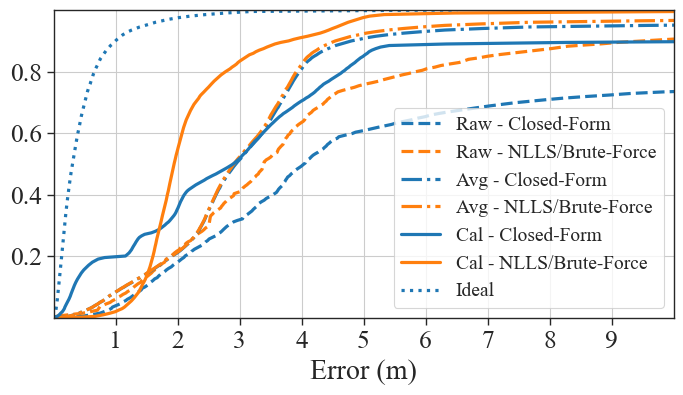

In [136]:
f, ax = plt.subplots(figsize=(8, 4))

sns.set_theme("paper", plot_style, font_scale=2.1, font='Times New Roman')

for ls_o in ls_ordered:
    data_to_plot = data_ecdf.loc[data_ecdf['label'] == ls_o,:]
    x = data_to_plot['error'].to_numpy()
    y = data_to_plot['prop'].to_numpy()

    ax.plot(x,y,linewidth=2.3,color=next(colorcycler),linestyle=next(linecycler),label=ls_o)

ax.set(xlim=(0, 10),ylim=(0,1))
ax.set(xlabel="Error (m)", ylabel = "")
ax.set(xticks=np.arange(1,10),yticks=[0.2,0.4,.6,.8])

ax.legend(title='',loc='lower right',ncols=1,fontsize=14)

# plt.savefig("pics/ECDF_final_4.pdf", format="pdf", bbox_inches='tight')

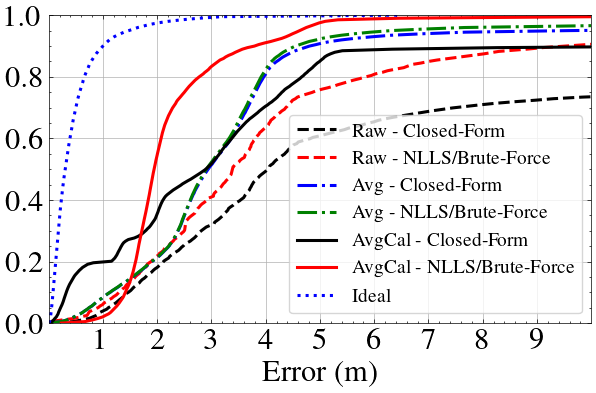

In [25]:
f, ax = plt.subplots(figsize=(7, 4),)
plt.rcParams.update({'font.size': 22})

# ls_ordered[4] = 'AvgCal - Closed-Form'
# ls_ordered[5] = 'AvgCal - NLLS/Brute-Force'

for ls_o in ls_ordered:
    data_to_plot = data_ecdf.loc[data_ecdf['label'] == ls_o,:]
    x = data_to_plot['error'].to_numpy()
    y = data_to_plot['prop'].to_numpy()

    if ls_o == 'Cal - Closed-Form':
        ax.plot(x,y,linewidth=2.2,linestyle=next(linecycler),label='AvgCal - Closed-Form')
    elif ls_o == 'Cal - NLLS/Brute-Force':
        ax.plot(x,y,linewidth=2.2,linestyle=next(linecycler),label='AvgCal - NLLS/Brute-Force')
    else:
        ax.plot(x,y,linewidth=2.2,linestyle=next(linecycler),label=ls_o)

ax.set(xlim=(0, 10),ylim=(-0.0,1.0))
ax.set(xlabel="Error (m)", ylabel = "")
ax.set(xticks=np.arange(1,10),yticks=[0,0.2,0.4,.6,.8,1])

ax.legend(title='',loc='lower right',ncols=1,fontsize=14,frameon=True)
ax.grid()

# plt.savefig("pics/ECDF_final.eps", format="eps", bbox_inches='tight')

In [27]:
# save .mat file
from scipy.io import savemat

In [28]:
data_dict = {name: col.values for name, col in data_ecdf.items()}


In [30]:
savemat('data.mat', data_dict)